# Ekman Transport Algorithm

In [3]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D

In [4]:
from matplotlib import rcParams

plt.rcParams['figure.figsize'] = (6, 6)

SMALL_SIZE = 10
MEDIUM_SIZE = 12
LARGE_SIZE = 14

plt.rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
plt.rc('text', usetex=True)

plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=LARGE_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=LARGE_SIZE)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=MEDIUM_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=LARGE_SIZE)   # fontsize of the figure title

# import matplotlib.font_manager
# import os
# fm = matplotlib.font_manager.json_load(os.path.expanduser("~/.cache/matplotlib/fontList.json"))

# fm.findfont("serif", rebuild_if_missing=False)

rcParams['mathtext.fontset'] = 'stix'
rcParams['font.family'] = 'STIXGeneral'

In [5]:
# Algorithm from Advanced Ocean Modeling by Jochen Kampf

dz = 10  # depth step
nz = 50  # total number of depth steps

# Ekman velocity vector inititalization
u = np.zeros(nz+1)
v = np.zeros(nz+1)
un = np.zeros(nz+1)
vn = np.zeros(nz+1)

rho = 1028.0  # density of seawater
az = 5e-2  # eddy viscosity coefficient
taux, tauy = 0.0, 0.5  # wind stress in Pascals

Omega = 7.29212e-5  # rotation rate of the Earth in rad/s
phi = 50  # latitude
f = 2 * Omega * np.sin(np.deg2rad(phi)) # Coriolis Parameter

t0 = 0  # start time in seconds
dt = 5  # time step in seconds
tn = 1*24*3600  # end time in seconds
nt = int((tn - t0)/dt)  # total number of time steps

# parameters for semi-implicit treatment of the Coriolis force
alpha = dt*f
beta = 0.25*alpha*alpha        



for t in range(nt):
    
    a = alpha
    b = 1.0-beta
    c = 1.0+beta
    
    # compute u and v at surface boundary
    u[0] = u[1]+dz*taux/rho/az
    v[0] = v[1]+dz*tauy/rho/az

    # compute u and v between surface and bottom boundaries
    for i in range(1, nz):

        diffu = dt*(az*(u[i-1]-u[i])/dz - az*(u[i]-u[i+1])/dz)/dz
        diffv = dt*(az*(v[i-1]-v[i])/dz - az*(v[i]-v[i+1])/dz)/dz
        un[i] = (b*u[i]+a*v[i] + 0.5*a*diffv+diffu)/c
        vn[i] = (b*v[i]-a*u[i] - 0.5*a*diffu+diffv)/c

    # compute u and v at bottom boundary (no stress)
    un[nz] = un[nz-1]
    vn[nz] = vn[nz-1]

    # update u and v
    for i in range(nz+1):

        u[i] = un[i]
        v[i] = vn[i]

## Coriolis Force

The Coriolis Force in the $x$ and $y$ directions is defined as:

$$\frac{1}{\rho}\frac{\partial \tau_x}{\partial z} = -fv$$
$$\frac{1}{\rho}\frac{\partial \tau_y}{\partial z} = -fu$$

where $\tau$ is the wind stress, $\rho$ is the density, $u$ is the East-West velocity, and $v$ is the North-South velocity. <br /><br />

Integrating over the entire Ekman layer:

$$\tau_x = -M_y f$$
$$\tau_y = -M_x f$$

where:

$$M_x = \int_0^z \rho u dz$$
$$M_y = \int_0^z \rho v dz$$

Here $M_x$ and $M_y$ represent the zonal and meridional mass transport terms with units of mass per unit time per unit length. Contrarily to common logic, north-south winds cause mass transport in the East-West direction. <br /><br />

Rewriting in terms of the vertical eddy viscosity term:

$$\frac{\partial \tau_x}{\partial z} = \rho A_z \frac{\partial^2 u}{\partial z^2}$$
$$\frac{\partial \tau_y}{\partial z} = \rho A_z \frac{\partial^2 v}{\partial z^2}$$

where $A_z$ is the vertical eddy viscosity coefficient.<br /><br />

This gives a set of differential equations of the form:

$$A_z \frac{\partial^2 u}{\partial z^2} = -fv$$
$$A_z \frac{\partial^2 v}{\partial z^2} = -fu$$

with boundary conditions:

<ul>
  <li> $(u,v) \to 0$ as $z \to \infty$
  <li> friction equals wind stress at the free surface ($z=0$)
</ul>

If we assume wind is blowing in the y-direction only, this simplifies to:

$$u_E = \pm V_0 cos(\frac{\pi}{4} + \frac{\pi}{D_E} z) e^{\frac{\pi}{D_E} z}$$
$$v_E = V_0 sin(\frac{\pi}{4} + \frac{\pi}{D_E} z) e^{\frac{\pi}{D_E} z}$$

where:
<ul>
<li> $u_E$ and $v_E$ represent Ekman transport in the $u$ and $v$ directions
<li> the plus-minus sign refers to positive in the Northern and negative in the Southern hemisphere
$$V_0 = \frac{\sqrt{2} \pi \tau}{D_E \rho |f|}$$
<li> $\tau$ is the wind stress at the sea surface
$$D_E = \pi (\frac{2 A_z}{|f|})^{1/2}$$
</ul>

In [6]:
def compute_ekman_velocity(wind, depth, latitude=50):

    u_wind, v_wind = wind
    z = depth
    phi = latitude

    rho_air = 1.225  # density of air (kg/m^3)
    rho_water = 1028  # density of seawater (kg/m^3)
    Cd =  1.3e-3 # ranges from (1.1 - 1.5) x 10^-3
    Omega = 7.2910e-5  # rotation rate of Earth (s^-1)
    Az = 5e-2   # m^2 s^−1;

    f = lambda phi : 2 * Omega * np.sin(phi)  # Coriolis parameter

    tau_x = lambda U, V : rho_air * Cd * U * np.sqrt(U**2 + V**2)  # wind stress x-component
    tau_y = lambda U, V : rho_air * Cd * V * np.sqrt(U**2 + V**2)  # wind stress y-component

    algorithm = 'textbook'
    #algorithm = 'wikipedia'

    if algorithm == 'textbook':

        # From Textbook
        V0x = tau_x(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
        V0y = tau_y(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
        V0 = np.sqrt(V0x**2 + V0y**2)
        theta = np.pi/2 - np.arctan2(V0y, V0x)

        a = np.sqrt(abs(f(phi))/(2 * Az))

        # note: clockwise rotation
        u_ekman = V0 * np.exp(a * z) * np.cos(np.pi / 4 + a * z) * (np.cos(theta) + np.sin(theta))
        v_ekman = V0 * np.exp(a * z) * np.sin(np.pi / 4 + a * z) * (np.cos(theta) - np.sin(theta))

    if algorithm == 'wikipedia':

        # From Wikipedia

        DE = np.pi * np.sqrt((2 * Az) / np.abs(f(phi)))

        V0x = (np.sqrt(2) * np.pi * tau_x(u_wind, v_wind)) / (DE * rho_air * np.abs(f(phi)))
        V0y = (np.sqrt(2) * np.pi * tau_y(u_wind, v_wind)) / (DE * rho_air * np.abs(f(phi)))
        V0 = np.sqrt(V0x**2 + V0y**2)
        theta = np.pi/2 - np.arctan2(V0y, V0x)

        # note: clockwise rotation
        u_ekman = V0 * np.cos(np.pi / 4 + (np.pi / DE) * z) * np.exp((np.pi / DE) * z) * (np.cos(theta) + np.sin(theta))
        u_ekman = V0 * np.sin(np.pi / 4 + (np.pi / DE) * z) * np.exp((np.pi / DE) * z) * (np.cos(theta) - np.sin(theta))

    return u_ekman, v_ekman 

In [7]:
min_depth = 0
max_depth = -1000
depth_step = -10
depth_vec = np.arange(min_depth, max_depth + depth_step, depth_step)
u_ekman_vec = np.zeros(len(depth_vec))
v_ekman_vec = np.zeros(len(depth_vec))

for i, depth in enumerate(depth_vec):

    u_ekman_vec[i], v_ekman_vec[i] = compute_ekman_velocity((20, 0), depth)

In [8]:
90 - np.arctan2(v_ekman_vec[0], u_ekman_vec[0])*180/np.pi

135.0

In [9]:
u_surface_current = 0.1
v_surface_current = 0

u_barotropic = u_surface_current - u_ekman_vec[0]
v_barotropic = v_surface_current - v_ekman_vec[0]

In [10]:
u_current_vec = u_barotropic + u_ekman_vec
v_current_vec = v_barotropic + v_ekman_vec
current_magnitude_vec = np.array([np.sqrt(u**2 + v**2) for u, v in zip(u_ekman_vec, v_ekman_vec)])
current_angle_vec = np.array([np.arctan2(v, u) for u, v in zip(u_ekman_vec, v_ekman_vec)])

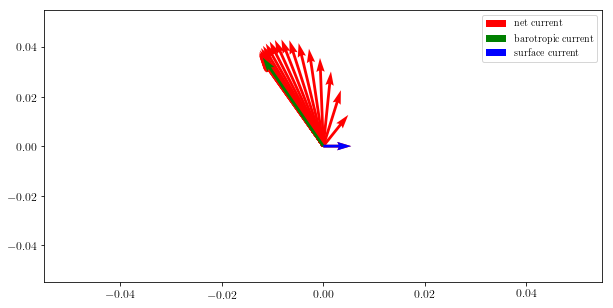

In [11]:
fig = plt.figure(figsize=(10,5))

plt.quiver(np.zeros(len(depth_vec)), np.zeros(len(depth_vec)), u_current_vec, v_current_vec, 
           scale=2, width=0.005, color='red', label='net current')

plt.quiver(0, 0, u_barotropic, v_barotropic, 
           scale=2, width=0.005, color='green', label='barotropic current')

plt.quiver(0, 0, u_surface_current, v_surface_current, 
           scale=2, width=0.005, color='blue', label='surface current')

#plt.quiver(0, 0, u_wind, v_wind, 
#           scale=2, width=0.005, color='black', label='wind velocity')

plt.legend()
plt.show()

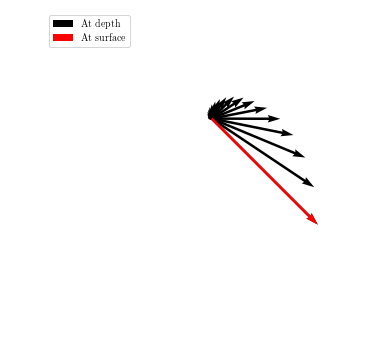

In [44]:
plt.figure(figsize=(6, 6))
scale = 1
plt.quiver(0, 0, u_ekman_vec, v_ekman_vec, scale=scale, label='At depth', )
plt.quiver(0, 0, u_ekman_vec[0], v_ekman_vec[0], color='red', scale=scale, label='At surface', 
          )

plt.axis('off')
plt.ylim(-0.1, 0.05)
plt.legend(loc='upper left')
#plt.gcf().subplots_adjust(left=0.8, right=1, bottom=0.7)
#plt.title('Ekman Spiral for Ocean with Eastward \n Surface Current and Winds')
plt.savefig('./plots/ekman_spiral.pdf', bbox_inches='tight')
plt.show()

<Figure size 720x360 with 0 Axes>

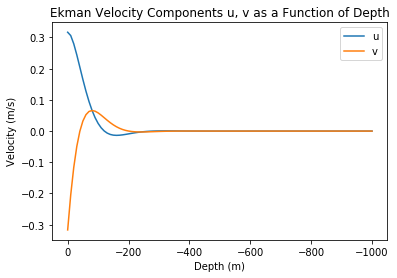

In [17]:
fig = plt.figure(figsize=(10,5))
fig, ax = plt.subplots()
ax.plot(depth_vec, u_ekman_vec, label='u')
ax.plot(depth_vec, v_ekman_vec, label='v')
ax.invert_xaxis()
ax.set_xlabel('Depth (m)')
ax.set_ylabel('Velocity (m/s)')
ax.set_title('Ekman Velocity Components u, v as a Function of Depth')
plt.legend()
plt.show()

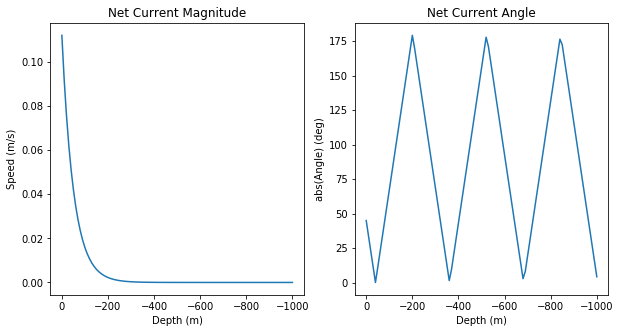

In [11]:
fig = plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1)
plt.title('Net Current Magnitude')
plt.ylabel('Speed (m/s)')
plt.xlabel('Depth (m)')
plt.plot(depth_vec, current_magnitude_vec)
plt.gca().invert_xaxis()
plt.subplot(1, 2, 2)
plt.title('Net Current Angle')
plt.ylabel('abs(Angle) (deg)')
plt.xlabel('Depth (m)')
plt.plot(depth_vec, abs(current_angle_vec)*180/np.pi)
plt.gca().invert_xaxis()
plt.show()

# Old Code

In [12]:
u_wind = 10
v_wind = 5

rho_air = 1.225  # density of air (kg/m^3)
rho_water = 1028  # density of seawater (kg/m^3)
Cd =  1.3e-3 # ranges from (1.1 - 1.5) x 10^-3
Omega = 7.2910e-5  # rotation rate of Earth (s^-1)
Az = 5e-2   # m^2 s^−1;

phi = 50  # latitude (degrees)
f = lambda phi : 2 * Omega * np.sin(phi)  # Coriolis parameter

tau_x = lambda U, V : rho_air * Cd * U * np.sqrt(U**2 + V**2)  # wind stress x-component
tau_y = lambda U, V : rho_air * Cd * V * np.sqrt(U**2 + V**2)  # wind stress y-component

V0x = tau_x(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
V0y = tau_y(u_wind, v_wind) / np.sqrt(rho_water**2 * np.abs(f(phi)) * Az)
V0 = np.sqrt(V0x**2 + V0y**2)

a = np.sqrt(abs(f(phi))/(2 * Az))

z = 10

u_ekman = V0 * np.exp(a * z) * np.cos(np.pi / 4 + a * z) * np.cos(np.arctan(V0y / V0x))
v_ekman = V0 * np.exp(a * z) * np.sin(np.pi / 4 + a * z) * np.sin(np.arctan(V0y / V0x))

u_ekman, v_ekman 

(0.08469550329666416, 0.06327521715741101)

In [13]:
z0 = -10; dz = -10; nz = 20
z_vec = np.array([z0 + i * dz for i in range(nz)])
u_ekman_vec = np.empty(nz)
v_ekman_vec = np.empty(nz)

for i, z in enumerate(z_vec):
    
    u_ekman_vec[i] = V0 * np.exp(a * z) * np.cos(np.pi / 4 + a * z) * np.cos(np.arctan(V0y / V0x))
    v_ekman_vec[i] = V0 * np.exp(a * z) * np.sin(np.pi / 4 + a * z) * np.sin(np.arctan(V0y / V0x))

In [14]:
x_vec = np.empty(nz); y_vec = np.empty(nz)
x_vec[0] = 0; y_vec[0] = 0

dt = 5  # seconds

for i in range(nz-1):
    
    x_vec[i+1] = x_vec[i] + u_ekman_vec[i] * dt
    y_vec[i+1] = y_vec[i] + v_ekman_vec[i] * dt

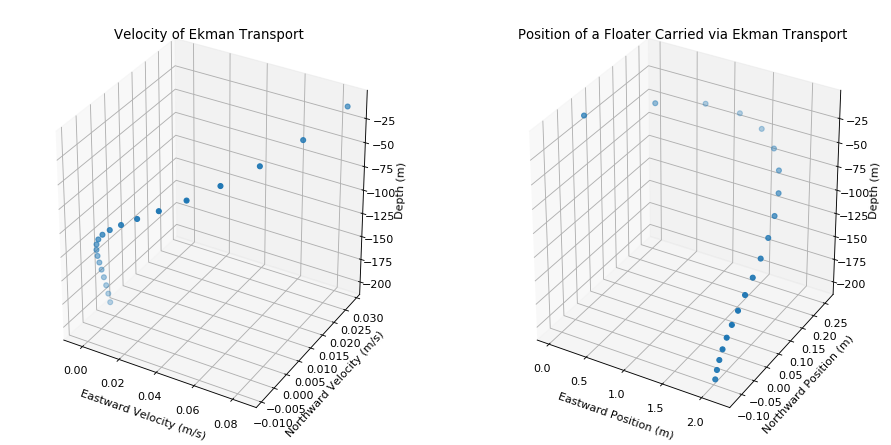

In [15]:
fig = plt.figure(figsize=(14, 7), dpi= 80)

ax = fig.add_subplot(1, 2, 1, projection='3d')
ax.set_zlabel('Depth (m)')
ax.set_xlabel('Eastward Velocity (m/s)')
ax.set_ylabel('Northward Velocity (m/s)')
ax.scatter(u_ekman_vec, v_ekman_vec, z_vec)
ax.set_title('Velocity of Ekman Transport')

ax = fig.add_subplot(1, 2, 2, projection='3d')
ax.set_zlabel('Depth (m)')
ax.set_xlabel('Eastward Position (m)')
ax.set_ylabel('Northward Position (m)')
ax.scatter(x_vec, y_vec, z_vec)
ax.set_title('Position of a Floater Carried via Ekman Transport')


plt.show()